# CUNEF
### Trabajo de Final de Master 

# Recoleccion y Pre-Procesado de datos Temporales

In [2]:
# Importamos las librerias que van a ser utilizados
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Importar los datos a trabajar

Importamos los datos con los que vamos a trabajar. Como estos tienen el mismo nombre solo con la diferencia del mes que se va a trabajar creamos un bucle para importar y concatenar todos los datos

In [3]:
ruta_base='../datos/01_trafico/'

# Importamos todos los datos con los que vamos a trabajar
lista_lista=[]

for i in range (5,13):
    if i < 10:
        location_doc=f'0{i}-2022.csv'
    else:
        location_doc=f'{i}-2022.csv'
    df_name = f'df_{location_doc[:-4]}'
    ruta_archivo=os.path.join(ruta_base,location_doc)
    df = pd.read_csv(ruta_archivo, sep =";")
    lista_lista.append((df_name,df))

# Unimos todos los dataframes para formar el dataframe final
df = pd.concat([tup[1] for tup in lista_lista], ignore_index=True)

# Seleccionamos solo las columnas con las que vamos a trabajar
df=df.loc[:,['id','fecha','intensidad']]

# Verificamos el dataframe creado
df.head(10)

,id,fecha,intensidad
0,1001,2022-05-01 00:00:00,1248
1,1001,2022-05-01 00:15:00,936
2,1001,2022-05-01 00:30:00,612
3,1001,2022-05-01 00:45:00,672
4,1001,2022-05-01 01:00:00,936
5,1001,2022-05-01 01:15:00,504
6,1001,2022-05-01 01:30:00,576
7,1001,2022-05-01 01:45:00,612
8,1001,2022-05-01 02:00:00,612
9,1001,2022-05-01 02:15:00,468


In [4]:
print(f'El dataset tiene una forma de {df.shape[0]} filas y de {df.shape[1]} columnas')
df.info()

El dataset tiene una forma de 95909681 filas y de 3 columnas
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95909681 entries, 0 to 95909680
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   id          int64 
 1   fecha       object
 2   intensidad  int64 
dtypes: int64(2), object(1)
memory usage: 2.1+ GB


De los datos que vamos a trabajar, solo se verifica que la variable de **"fecha"** necesitamos realizar una transformación para pasarla de tipo objeto a tipo datetime

### 2. Corregimos la columna de tiempo

In [5]:
# Definimos la columna de fecha en formato de datetime
df['fecha']=pd.to_datetime(df['fecha'], format = '%Y-%m-%d %H:%M:%S')

# Verificamos que este correctamente asignado el valor de la columna
df['fecha'].dtypes

dtype('<M8[ns]')

### 3. Identificación de sensores con valores faltantes y selección de threshold

**3.1 Identificación de variables nulas**\
El primer paso a ejecutar es crear una lista con todos los posibles sensores que se encuentren. Luego creamos un nuevo dataset con todas las frecuencias que existen cada 15 min desde la fecha minima hasta la maxima del dataframe original y unimos todos los sensores unicos con todos los intervalos de fecha. Al final este nuevo intervalo creado, es unido al dataframe original mediante la columan de fecha para obtenerlos datos de intensidad en todos los intervalos recopilados

In [6]:
# Creamos un dataframe con todos los ID que se tiene de los sensores
id_list=df['id'].unique()
id_list=pd.DataFrame(id_list, columns=['id'])

# Verificamos cuantos sensores tenemos en nuestra lista
print(f'El numero de sensores que existe en Madrid es de {len(id_list)}')

# Creamos intervalos de 15 min entre la fecha min y la fecha maxima
df_date = pd.date_range(start=df['fecha'].min(), end=df['fecha'].max(), freq='15min') 
df_date = pd.DataFrame(df_date, columns=['fecha'])

# Unimos el dataframe de ID de sensores que existen con el dataframe de todas las fechas posibles 
df_dates_id = df_date.merge(id_list, how='cross')

El numero de sensores que existe en Madrid es de 4534


Comprobamos que ambos dataframes tengan la misma cantidad de valores dentro del rango de fechas

In [7]:
# Cantidad de valores en dataframe original construido por rango de fechas
print(f'La cantidad de filas del dataframe creado a partir de un rango de fecha es de {len(df_date)}')

# Cantidad de valores para cada uno de los ID de sensores
df_dates_id.groupby('id').count().head(3)

La cantidad de filas del dataframe creado a partir de un rango de fecha es de 23520


,fecha
id,
1001,23520
1002,23520
1003,23520


Por ultimo, unimos el dataframe creado con todas las fechas para cada ID con los datos extraidos del trafico de Madrid

In [8]:
df_traf_date=df.merge(df_dates_id, on=['id','fecha'], how='outer').sort_values(by=['id','fecha'])
df_traf_date

,id,fecha,intensidad
0,1001,2022-05-01 00:00:00,1248.0
1,1001,2022-05-01 00:15:00,936.0
2,1001,2022-05-01 00:30:00,612.0
3,1001,2022-05-01 00:45:00,672.0
4,1001,2022-05-01 01:00:00,936.0
...,...,...,...
106637501,50335653,2022-12-31 22:45:00,NaN
106638092,50335653,2022-12-31 23:00:00,NaN
106638660,50335653,2022-12-31 23:15:00,NaN
106639161,50335653,2022-12-31 23:30:00,NaN


**3.2 Verificamos los sensores con nulos**\
Verificamos cual es el umbral a utilizar para la seleccion de sensores y filtramos la taba original de intensidad partiendo de los sensores con la cantidad de nulos seleccionada

Una vez tenemos todas las fechas posibles en el dataset de transito, verificamos cuales son los sensores con mayor cantidad de valores nulos

In [9]:
#Creamos un dataframe que identifique cada nulo de cada sensor
null_id=df_traf_date['intensidad'].isnull().groupby(df_traf_date['id']).sum().sort_values(ascending=False).reset_index()
null_df=pd.DataFrame(null_id)
null_df.columns=['id','num_nulls']

Identificamos los sensores que sobrepasen el valor de nulos definidos en el threshold

In [10]:
# Creamos una columna que indique cuando la cantidad de nulos es mayor del 10% del total de filas
th=len(df_traf_date)/len(id_list)*.1
print(th)

null_df['big_10perc']=null_df['num_nulls'].apply(lambda x: 1 if x >= th else 0)
null_df.head(5)

2352.0


,id,num_nulls,big_10perc
0,6051,23519,1
1,479309,23519,1
2,5869,23518,1
3,6050,23518,1
4,5946,23518,1


Verificamos la proporcion de datos con mas del 10% de valores faltantes y los que cuentan con menos de 10%

In [11]:
# Verificamos la proporcion de sensores seleccionados del total de valores
df_summary=pd.DataFrame(null_df.groupby(['big_10perc'])['num_nulls'].count())
df_summary.columns=['id_cant']
df_summary['id_perc_nulls']=round(null_df.groupby(['big_10perc'])['num_nulls'].count()/len(id_list)*100,3)
df_summary

,id_cant,id_perc_nulls
big_10perc,,
0,3444,75.959
1,1090,24.041


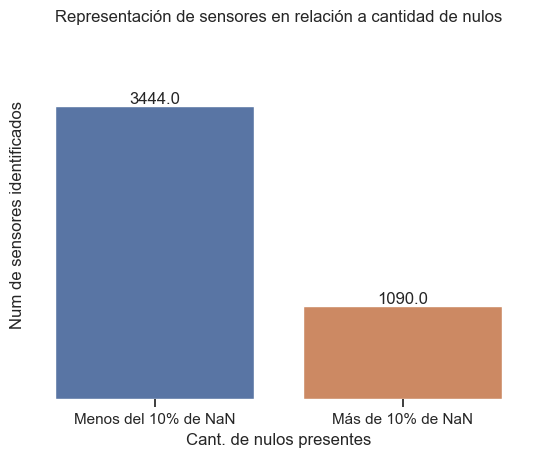

In [12]:
# Reseteamos el indice para contar con la columna de mayor o no al 10%
df_summary=df_summary.reset_index()

# Creamos la gráfica de valores
sns.set(style="ticks")

ax=sns.barplot(df_summary,x='big_10perc',y='id_cant')
ax.set_xticklabels(['Menos del 10% de NaN','Más de 10% de NaN'])
ax.set_yticks([])

# Identificamos los títulos de los ejes
ax.set_title("Representación de sensores en relación a cantidad de nulos")
ax.set_ylabel("Num de sensores identificados")
ax.set_xlabel("Cant. de nulos presentes")

# Definimos los valores dentro de la grafica
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

# Incrementamos el rango de valores en el eje Y y eliminamos margen colocado
ax.set_ylim(0, ax.get_ylim()[1] * 1.2)
ax.set_frame_on(False)

**3.3 Seleccionamos sensores a trabajar**\
Seleccionamos los sensores que no sobrepasen un threshold definido de 10% de datos y filtramos el dataset que contiene los valores de intensida

In [13]:
# Creamos lista para identificar cuales sensores seran seleccionados
sensores_select=null_df[null_df['big_10perc']==0]['id']

# Identificamos los sensores que no sobrepasan el 10 porciento en el dataframe original para colocarles el tag 
df_traf_date=df_traf_date[df_traf_date['id'].isin(sensores_select)]
df_traf_date

,id,fecha,intensidad
0,1001,2022-05-01 00:00:00,1248.0
1,1001,2022-05-01 00:15:00,936.0
2,1001,2022-05-01 00:30:00,612.0
3,1001,2022-05-01 00:45:00,672.0
4,1001,2022-05-01 01:00:00,936.0
...,...,...,...
106637471,10978,2022-12-31 22:45:00,NaN
95729795,10978,2022-12-31 23:00:00,16.0
95729796,10978,2022-12-31 23:15:00,0.0
95729797,10978,2022-12-31 23:30:00,6.0


In [14]:
print(f'EL numero de sensores únicos que cuentan con menos de un 10% de valores faltantes es de {len(df_traf_date.id.unique())} sensores y el nuevo dataset es de:\n {df_traf_date.shape[0]} filas y {df_traf_date.shape[1]} columnas')

EL numero de sensores únicos que cuentan con menos de un 10% de valores faltantes es de 3444 sensores y el nuevo dataset es de:
 81002880 filas y 3 columnas


Este dataset será exportado para verificar en Tableau cuales son los sensores con los que vamos a trabajar debido a su cantidad de nulos

In [15]:
# Creamos un dataset solo con el numero del sensor y si posee o no menos de un 10%
dataset_sensors=pd.DataFrame(df_traf_date['id'].unique(), columns=['id'])
dataset_sensors['select_column']=True
dataset_sensors

# Exportar el dataset en formato csv 
dataset_sensors.to_csv('../datos/03_procesados/dataset_sensors_final.csv')

### 4. Seleccionamos los sensores con los que vamos a trabajar

Con los sensores seleccionados mediante la visualizacion en Tableau de los sensores proximos de una zona en especifico vamos a hacer solo el dataset de estos sensores.

In [16]:
#Descargamos los sensores con los que vamos a trabajar con la eleccion realizada en Tableau
sensores_tableau=pd.read_excel("../datos/03_procesados/sensores_seleccion_tableau.xlsx", header = 1)
sensores_tableau=sensores_tableau.loc[:,'Id']

# Creamos una columna para identificar cuales fueron los sensores seleccionados
df_traf_date['sensor_select']=df_traf_date['id'].isin(sensores_tableau)

# Filtramos a solo los sensores que se encuentran como True
df_traf_date=df_traf_date[df_traf_date['sensor_select']==True].reset_index(drop=True)
df_traf_date=df_traf_date.drop(['sensor_select'], axis=1)
df_traf_date

C:\Users\karla\AppData\Local\Temp\ipykernel_32780\2096082545.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_traf_date['sensor_select']=df_traf_date['id'].isin(sensores_tableau)


,id,fecha,intensidad
0,3396,2022-05-01 00:00:00,158.0
1,3396,2022-05-01 00:15:00,159.0
2,3396,2022-05-01 00:30:00,156.0
3,3396,2022-05-01 00:45:00,172.0
4,3396,2022-05-01 01:00:00,118.0
...,...,...,...
7361755,10885,2022-12-31 22:45:00,148.0
7361756,10885,2022-12-31 23:00:00,144.0
7361757,10885,2022-12-31 23:15:00,156.0
7361758,10885,2022-12-31 23:30:00,183.0


In [17]:
print(f'El número de sensores final para el análisis es de: {len(df_traf_date.id.unique())} sensores')

El número de sensores final para el análisis es de: 313 sensores


### 5. Llenamos los valores faltantes del dataset

Con los valores en el rango de tiempo establecido, vamos a eliminar los valores faltantes que han quedado como nulos con el valor previo del sensor con el que se esta trabajando

In [23]:
#Creamos nuevas variables para trabajarlas en el bucle
new_list=[]
prev_value = 0

# Creamos el bucle para hacer una nueva lista y eliminar los valores NaN con el ultimo valor previo colectado
for num_element, element in enumerate(df_traf_date['intensidad']):
    if np.isnan(element):
        new_list.append(prev_value)
    else:
        new_list.append(element)
        prev_value=element

# Creamos una nueva columna con la lista sin nulos que fue creada
df_traf_date['intensidad']=new_list

# Verificamos la salida de la nueva columna creada
df_traf_date

Ajustamos el intervalo de tiempo de cada 15 min a cada 30 min

In [27]:
# Agrupamos el dataset por la columna de id
df_grouped=df_traf_date.loc[:,['id','fecha','intensidad']].groupby('id')

# Por cada id agrupamos cada 30 min
df_resampled = df_grouped.apply(lambda x: x.set_index('fecha').resample('30min').sum(min_count=1))

# Eliminamos la columna de id que ha sido creada 2 veces
df_resampled.drop(['id'], axis=1, inplace=True)
df_resampled.reset_index(inplace=True)

# Verificamos el dataframe
df_resampled

,id,fecha,intensidad
0,3396,2022-05-01 00:00:00,317.0
1,3396,2022-05-01 00:30:00,328.0
2,3396,2022-05-01 01:00:00,257.0
3,3396,2022-05-01 01:30:00,248.0
4,3396,2022-05-01 02:00:00,271.0
...,...,...,...
3680875,10885,2022-12-31 21:30:00,364.0
3680876,10885,2022-12-31 22:00:00,342.0
3680877,10885,2022-12-31 22:30:00,315.0
3680878,10885,2022-12-31 23:00:00,300.0


In [28]:
# Verificamos cuantos valores faltantes existen en el dataset
pd.DataFrame(df_resampled.isna().sum()).T 

,id,fecha,intensidad
0,0,0,0


### 6. Pasar a formato para Stellargraph

In [29]:
# Seleccionamos las filas con las que vamos a trabajar
df_stellarg=df_resampled.loc[:,['id','fecha','intensidad']]
df_stellarg.head(10)

,id,fecha,intensidad
0,3396,2022-05-01 00:00:00,317.0
1,3396,2022-05-01 00:30:00,328.0
2,3396,2022-05-01 01:00:00,257.0
3,3396,2022-05-01 01:30:00,248.0
4,3396,2022-05-01 02:00:00,271.0
5,3396,2022-05-01 02:30:00,300.0
6,3396,2022-05-01 03:00:00,167.0
7,3396,2022-05-01 03:30:00,216.0
8,3396,2022-05-01 04:00:00,161.0
9,3396,2022-05-01 04:30:00,180.0


In [30]:
# Creamos una nueva lista con los numeros del 0 al valor maximo de cada id para empezar a crear el formato de StellarGraph
list_date_sg=[]

for id_num in id_list['id']:
    for counter in range(0,len(df_stellarg[df_stellarg['id']==id_num])):
        list_date_sg.append(counter)

# Unimos la lista creada para la fecha con el dataset de stellagraph con el nombre de fecha_sg
df_stellarg['fecha_sg']=list_date_sg

# Seleccionamos las columnas con las que vamos a trabajar para el formato de StellarGraph
df_stellarg=df_stellarg.loc[:,['id','intensidad','fecha_sg']]
df_stellarg

,id,intensidad,fecha_sg
0,3396,317.0,0
1,3396,328.0,1
2,3396,257.0,2
3,3396,248.0,3
4,3396,271.0,4
...,...,...,...
3680875,10885,364.0,11755
3680876,10885,342.0,11756
3680877,10885,315.0,11757
3680878,10885,300.0,11758


In [31]:
# Colocamos el nuevo dataset en el formato necesario para utilizarlo en stellargraph
df_stellarg=df_stellarg.pivot(index='id', columns='fecha_sg', values='intensidad')
print(df_stellarg.shape)
df_stellarg.head(10)

(313, 11760)


fecha_sg,0,1,2,3,4,5,6,7,8,9,...,11750,11751,11752,11753,11754,11755,11756,11757,11758,11759
id,,,,,,,,,,,,,,,,,,,,,
3396,317.0,328.0,257.0,248.0,271.0,300.0,167.0,216.0,161.0,180.0,...,323.0,394.0,487.0,592.0,566.0,359.0,212.0,177.0,145.0,183.0
3397,551.0,512.0,444.0,420.0,352.0,308.0,272.0,300.0,319.0,248.0,...,495.0,604.0,727.0,912.0,645.0,534.0,371.0,215.0,141.0,161.0
3407,711.0,535.0,681.0,621.0,564.0,518.0,561.0,438.0,355.0,384.0,...,403.0,380.0,433.0,591.0,530.0,510.0,328.0,242.0,232.0,270.0
3435,1297.0,1359.0,1243.0,1119.0,933.0,897.0,893.0,660.0,616.0,524.0,...,1230.0,1402.0,1462.0,2022.0,1638.0,1112.0,598.0,320.0,317.0,265.0
3465,1226.0,1128.0,908.0,776.0,649.0,444.0,486.0,380.0,318.0,318.0,...,340.0,90.0,90.0,637.0,819.0,745.0,448.0,297.0,330.0,376.0
3497,302.0,296.0,393.0,296.0,255.0,266.0,267.0,175.0,139.0,184.0,...,240.0,240.0,343.0,686.0,620.0,279.0,188.0,118.0,130.0,120.0
3501,84.0,128.0,111.0,57.0,69.0,47.0,41.0,62.0,30.0,41.0,...,164.0,180.0,200.0,193.0,176.0,200.0,83.0,48.0,33.0,53.0
3502,124.0,129.0,80.0,78.0,95.0,64.0,36.0,41.0,39.0,63.0,...,160.0,228.0,196.0,232.0,199.0,124.0,70.0,45.0,44.0,32.0
3503,241.0,236.0,163.0,144.0,148.0,119.0,80.0,82.0,93.0,57.0,...,263.0,368.0,342.0,432.0,479.0,313.0,125.0,55.0,95.0,39.0


Exportamos los datos a csv para trabajar en un futuro

In [ ]:
df_stellarg.to_csv('../datos/03_procesados/datos_procesados.csv')

## Verificamos las características de nuestros datos temporales

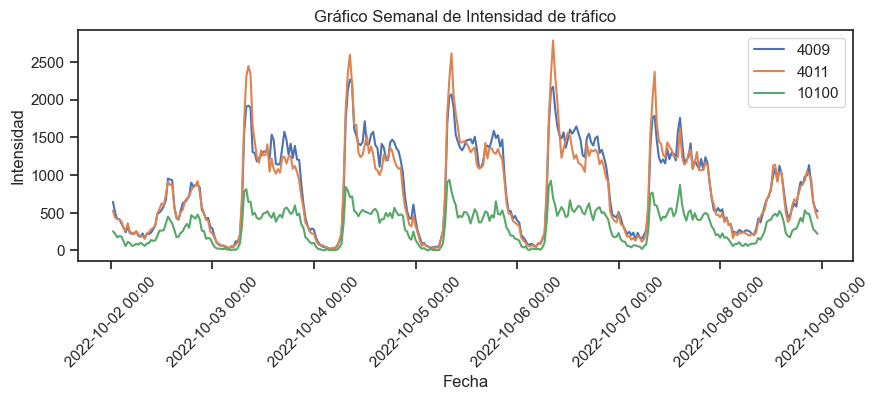

In [159]:
import matplotlib.dates as mdates

time_eval=[10100, 4011, 4009]
eval_time=df_resampled[df_resampled['id'].isin(time_eval)]

eval_time=eval_time[(eval_time['fecha']>'2022-10-02 00:00:00')&(eval_time['fecha']<'2022-10-08 23:30:00')]

plt.figure(figsize=(10, 3))

for idx in eval_time['id'].unique():
    id_data = eval_time[eval_time['id'] == idx]
    plt.plot(id_data['fecha'], id_data['intensidad'],label=f'{idx}')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.xticks(rotation=45)
plt.xlabel('Fecha')
plt.ylabel('Intensidad')
plt.title('Gráfico Semanal de Intensidad de tráfico')
plt.legend()

C:\Users\karla\AppData\Local\Temp\ipykernel_32780\694433951.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_time['timestamp'] = pd.to_datetime(eval_time['fecha'])
C:\Users\karla\AppData\Local\Temp\ipykernel_32780\694433951.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  eval_time = eval_time.groupby(['id', pd.Grouper(key='fecha', freq='D')]).sum()


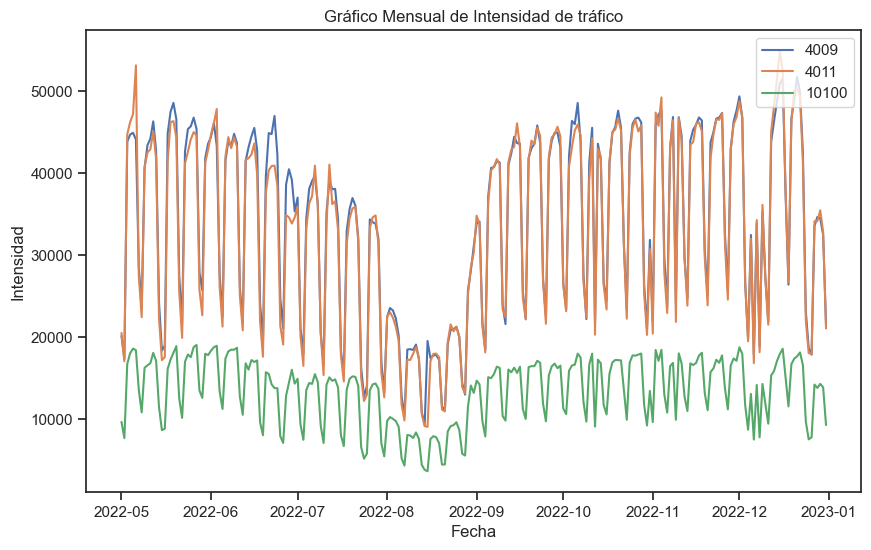

In [160]:
time_eval=[10100, 4011, 4009]
eval_time=df_resampled[df_resampled['id'].isin(time_eval)]

# eval_time=eval_time[(eval_time['fecha']>'2022-10-02 00:00:00')&(eval_time['fecha']<'2022-10-08 23:30:00')]
eval_time['timestamp'] = pd.to_datetime(eval_time['fecha'])

eval_time = eval_time.groupby(['id', pd.Grouper(key='fecha', freq='D')]).sum()
eval_time=eval_time.reset_index()

eval_time_2 = eval_time.groupby(['id', pd.Grouper(key='fecha', freq='M')]).sum()
eval_time_2=eval_time_2.reset_index()

plt.figure(figsize=(10, 6))

for idx in eval_time['id'].unique():
    id_data = eval_time[eval_time['id'] == idx]
    plt.plot(id_data['fecha'], id_data['intensidad'],label=f'{idx}')

plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Fecha')
plt.ylabel('Intensidad')
plt.title('Gráfico Mensual de Intensidad de tráfico')
plt.legend(loc='upper right')